In [1]:
from jyro.simulator import (Robot, Pioneer, Pioneer16Sonars, 
                            PioneerFrontLightSensors, Camera,
                            VSimulator)
import random
import numpy as np

In [2]:
robot = Pioneer("Pioneer", 3.5, 2, 0)

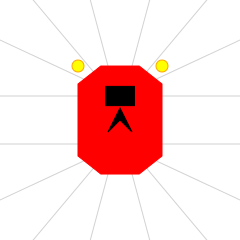

In [3]:
robot.addDevice(Pioneer16Sonars())
robot.addDevice(Camera())
light_sensors = PioneerFrontLightSensors(3.0)
light_sensors.lightMode = 'ambient'
robot.addDevice(light_sensors)

In [4]:
def worldf(physics):
    physics.addBox(0, 0, 4, 4, fill="backgroundgreen", wallcolor="gray")
    physics.addLight(2, 0.75, 1.0) # increased brightness for new linear version of lights

In [5]:
sim = VSimulator(robot, worldf)

In [16]:
camera = robot.device["camera"]

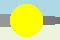

In [26]:
image = camera.getImage()
image

In [28]:
image.size

(60, 40)

In [29]:
data = camera.getData()
data.shape

(40, 60, 3)

In [30]:
robot.move(0.50, 0.35)

In [31]:
sim.step()

In [32]:
def random_action():
    """Generate a random action from a limited set of possible settings"""
    possible = [-1.0, -0.5, 0.0, 0.5, 1.0]
    return [random.choice(possible), random.choice(possible)]

def get_senses(robot):
    light = robot["light"].getData()
    sonar = [v/3.0 for v in robot["sonar"].getData()]
    camera = robot["camera"].getData()
    return [light, sonar, camera]

In [33]:
senses = get_senses(robot)
list(map(len, senses))

[2, 16, 40]

In [34]:
def brain(robot):
    senses = get_senses(robot)
    net.propagate(senses)
    translate, rotate = random_action()
    #self.move(translate, rotate)
    robot.move(0.50, 0.35)

In [35]:
robot.brain = brain

In [36]:
from conx import Network, Layer, FlattenLayer, SGD, ImageLayer, Conv2DTransposeLayer
import numpy as np

Using Theano backend.


In [37]:
net = Network("Robot Prediction Network")
net.add(Layer("light", 2))
net.add(Layer("sonar", 16))
net.add(ImageLayer("camera", (40, 60), 3))
net.add(FlattenLayer("flatten"))
net.add(Conv2DTransposeLayer("conv", 16, (3,3)))
net.add(Layer("hidden", 50, activation="relu"))
net.add(Layer("output1", 2, activation="sigmoid"))
net.add(Layer("hidden2", 5, activation="sigmoid"))
net.add(Layer("hidden3", 10, activation="sigmoid"))
net.add(Layer("hidden4", 10, activation="sigmoid"))
net.add(Layer("output2", 5, activation="sigmoid"))

In [38]:
net.connect("sonar", "hidden")
net.connect("light", "hidden")
net.connect("camera", "conv")
net.connect("conv", "flatten")
net.connect("flatten", "hidden2")
net.connect("hidden", "hidden2")
net.connect("hidden2", "hidden3")
net.connect("hidden3", "output2")
net.connect("hidden3", "hidden4")
net.connect("hidden4", "output1")

In [39]:
net.compile(optimizer="adam", error="mse")
net.config["hspace"] = 200

In [40]:
net

<IPython.core.display.Javascript object>

In [41]:
net.propagate(get_senses(robot))

[[0.6178123354911804, 0.6090826392173767],
 [0.42568066716194153,
  0.44594305753707886,
  0.5795302391052246,
  0.3958825170993805,
  0.5979085564613342]]

In [42]:
net.dashboard()

<IPython.core.display.Javascript object>

In [44]:
sim.widget